In [2]:
# taken from Karpathy's micrograd
import math
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2
from helper import draw_dot


class Value:
    def __init__(self, data, _children=(), _op="", label="") -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op="+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data * other.data, _children=(self, other), _op="*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return -1.0 * self

    def exp(self):
        out = Value(math.exp(self.data), _children=(self,), _op="exp")

        def _backward():
            self.grad += out.grad * out.data

        out._backward = _backward
        return out

    def __pow__(self, other):  # self ** other
        if not (isinstance(other, int) or isinstance(other, float)):
            assert False
        out = Value(self.data**other, _children=(self,), _op="**")

        def _backward():
            self.grad += out.grad * (other * (self.data ** (other - 1.0)))

        out._backward = _backward
        return out

    def __sub__(self, other):
        return self + other.__neg__()

    def __truediv__(self, other):  # self/other
        return self * (other ** (-1.0))

    def tanh(self):
        e = (2 * self).exp()
        return (e - 1) / (e + 1)

    def softmax():
        pass

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
            return

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [4]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w1
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.88137, label="b")

w1x1 = w1 * x1
w1x1.label = "w1*x1"
w2x2 = w2 * x2
w2x2.label = "w2*x2"
w1x1w2x2 = w1x1 + w2x2
w1x1w2x2.label = "w1*x1 + w2*x2"
z = w1x1w2x2 + b
z.label = "z"
# a = z.tanh(); a.label = "a"

e = (2 * z).exp()
a = (e - 1) / (e + 1)

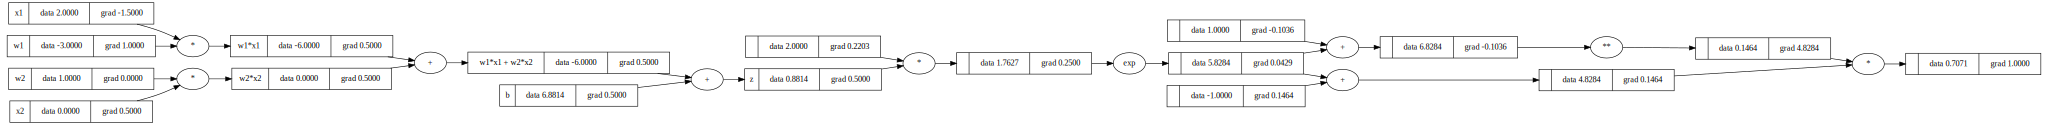

In [5]:
from helper import draw_dot

a.backward()
draw_dot(a)

In [120]:
import random


class Neuron:
    def __init__(self, nin):
        self.weights = [Value(random.uniform(-1.0, 1.0)) for i in range(nin)]
        self.bias = Value(random.uniform(-1.0, 1.0))

    def __call__(self, x):  # forward pass
        _sum = self.bias
        for xi, wi in zip(x, self.weights):
            _sum = _sum + (xi * wi)
        return _sum.tanh()

    def parameters(self):
        return self.weights + [self.bias]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for i in range(nout)]

    def __call__(self, x):  # x is nin
        out = [neuron(x) for neuron in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
        # return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        self.layers = []
        prev = nin
        for i in nouts:
            self.layers.append(Layer(prev, i))
            prev = i

    def __call__(self, x):  # forward pass
        y = x
        for i in self.layers:
            y = i(y)
        return y

    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params

In [121]:
net = MLP(3, [4, 4, 1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [net(x) for x in xs]

[Value(data=0.7314358228821312),
 Value(data=0.7999750490721166),
 Value(data=0.8583563900091744),
 Value(data=0.2434636526515217)]

In [122]:
alpha = 0.01

for i in range(100):
    ypred = [net(x) for x in xs]

    loss = Value(0.0)
    for y, yp in zip(ys, ypred):
        loss = loss + (yp - y) ** 2

    # print(loss.data)
    loss.backward()
    for value in net.parameters():
        value.data -= alpha * value.grad
        value.grad = 0.0